In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline

In [4]:
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform

In [5]:
# Define some arbitrary probability distribution
def p1(x):
    if np.all(x > 0) and np.all(x < 1):
        return m.exp(-np.sum(x)/len(x)) * np.cos(m.pi*np.sum(x))**2
    return 0

def p2(x):
    if np.all(x > 0) and np.all(x < 1):
        return m.exp(-np.sum(x)/len(x)) * np.cos(2*m.pi*np.sum(x))**2 
    else:
        return 0
def generate(n, d):
    x = np.zeros((n,d))
    y = np.zeros((n,1), dtype=int)

    counter = 0
    while(counter < n):
        # Select a channel at random
        if r.random() < 0.5:
            y[counter] = 0
        else:   
            y[counter] = 1

        while(True):
            # Get a point
            x_trial = np.random.rand(d)
            if y[counter] == 0:
                if r.random() < p1(x_trial):
                    x[counter] = x_trial
                    counter += 1
                    break
            elif y[counter] == 1:
                if r.random() < p2(x_trial):
                    x[counter] = x_trial
                    counter +=1 
                    break
    return x,y

In [6]:
dim = 2
data_size = int(1e6)
x, y = generate(data_size, dim)

In [7]:
num_layers = 5
base_dist = BoxUniform(torch.zeros(dim), torch.ones(dim))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=dim))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=dim, 
        hidden_features=100,
        num_bins=15,
        num_blocks=3,
        context_features=1
    ))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [8]:
n_epochs = 10
batch_size = 1000
n_batches = m.ceil(data_size/batch_size)

x_torch = torch.tensor(x, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_torch.size()[0])    

    # Loop over batches
    cum_loss = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, data_size-1 )
        indices = permutation[batch_begin:batch_end]
        batch_x = x_torch[indices]
        batch_y = y_torch[indices]
        
        # Take a step
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x, context=batch_y).mean()
        loss.backward()
        optimizer.step()

        # Compute cumulative loss
        cum_loss = (cum_loss*batch + loss.item())/(batch+1)

        print("epoch = ", epoch, "batch = ",batch+1, "/", n_batches, "loss = ", cum_loss)

h =  7 batch =  231 / 1000 loss =  -0.3064261731647309
epoch =  7 batch =  232/ 1000 loss =  -0.30641108417305446
epoch =  7 batch =  233 / 1000 loss =  -0.30647411226203
epoch =  7 batch =  234 / 1000 loss =  -0.3066671256326202
epoch =  7 batch =  235 / 1000 loss =  -0.3066699617720664
epoch =  7 batch =  236 / 1000 loss =  -0.30667466013613387
epoch =  7 batch =  237 / 1000 loss =  -0.30667582921337977
epoch =  7 batch =  238 / 1000 loss =  -0.30669345086863053
epoch =  7 batch =  239 / 1000 loss =  -0.3067825102407064
epoch =  7 batch =  240 / 1000 loss =  -0.30690763083597017
epoch =  7 batch =  241 / 1000 loss =  -0.30709494681279187
epoch =  7 batch =  242 / 1000 loss =  -0.30709482150629525
epoch =  7 batch =  243 / 1000 loss =  -0.30719033361952974
epoch =  7 batch =  244 / 1000 loss =  -0.3070548543187438
epoch =  7 batch =  245 / 1000 loss =  -0.3071754889828818
epoch =  7 batch =  246 / 1000 loss =  -0.30713393884461093
epoch =  7 batch =  247 / 1000 loss =  -0.307078851258

KeyboardInterrupt: 

In [15]:
with torch.no_grad():
    y_labels = torch.tensor(np.array([0,1]), dtype=torch.float32).reshape(-1,1)
    x_flow = flow.sample(int(5e5), y_labels).numpy()

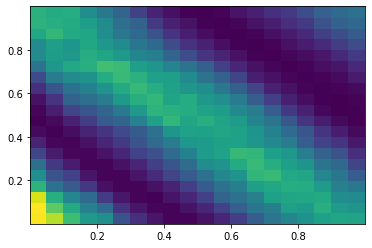

In [16]:
plt.hist2d(x_flow[0,:,0], x_flow[0,:,1], bins=20)
plt.show()

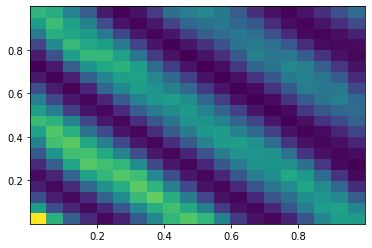

In [17]:
plt.hist2d(x_flow[1,:,0], x_flow[1,:,1], bins=20)
plt.show()

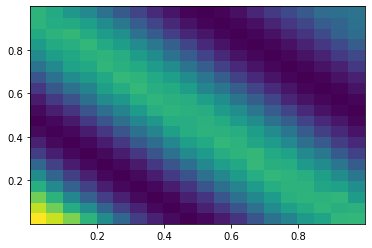

In [13]:
plt.hist2d((x[(y == 0)[:,0]])[:,0], (x[(y == 0)[:,0]])[:,1], bins = 20)
plt.show()

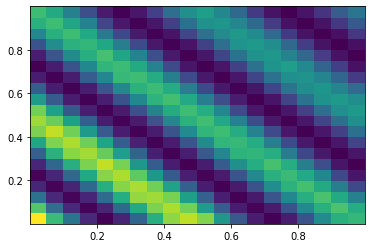

In [14]:
plt.hist2d((x[(y == 1)[:,0]])[:,0], (x[(y == 1)[:,0]])[:,1], bins = 20)
plt.show()

In [29]:
np.where(y==1)

(array([     2,      3,      4, ..., 999996, 999997, 999999]),
 array([0, 0, 0, ..., 0, 0, 0]))